**Fraud Analytics Assignment**  
**Title: Synthetic data generation using Variational Autoencoder**  
---
**Group members:**  
**Name&emsp;: Dindorkar Mayuresh Rajesh**  
**Roll No&nbsp;: CS23MTECH14007**  

**Name&emsp;: Sanyam Kaul**  
**Roll No&nbsp;: CS23MTECH14011**  

**Name&emsp;: Shrenik Ganguli**  
**Roll No&nbsp;: CS23MTECH14014**  

**Name&emsp;: Morey Piyush Prabhakar**  
**Roll No&nbsp;: AI23MTECH14003**  

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from scipy.stats import entropy, ks_2samp

**Checking GPU availability:**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


---
**Utility Functions and classes:**

In [3]:
def train_VAE(vae, optimizer, epochs, train_loader, vae_loss_function):
    epoch_loss_list = []
    vae.train()
    for epoch in range(epochs):
        all_batches_loss = 0
        with tqdm(train_loader, unit='batch') as t_loader:
            for batch_idx, x in enumerate(t_loader):
                x = x.to(device)
                optimizer.zero_grad()
                x_hat, mean, log_var = vae(x)
                loss = vae_loss_function(x, x_hat, mean, log_var)
                loss.backward()
                optimizer.step()
                all_batches_loss += loss.item()
                t_loader.set_postfix(loss=loss.item())  # Optional: Display individual batch loss

        epoch_loss_list.append(all_batches_loss / len(train_loader))
        print(f'Epoch {epoch+1}, Loss: {epoch_loss_list[-1]}')
    return epoch_loss_list
def get_column_names():
    return ['User', 'Card', 'Year', 'Amount', 'Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Is Fraud?']

In [4]:
def plot_epoch_vs_loss(epochs, loss, title):
  plt.plot(epochs, loss)
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.title(title)
  plt.show()

In [5]:
class Custom_Dataset(Dataset):
    def __init__(self, tensor):
        self.tensor = tensor

    def __getitem__(self, idx):
        return self.tensor[idx]

    def __len__(self):
        return len(self.tensor)

In [6]:
def plot_columnwise_distribution(data, synthetic_df):
    column_names = get_column_names()
    num_plots = len(column_names)
    fig, axes = plt.subplots(num_plots, 1, figsize=(8, 44))
    for i, col in enumerate(column_names):
        data[col].hist(ax=axes[i], color='blue', alpha=0.7, label='Real Data', bins=20) 
        synthetic_df[col].hist(ax=axes[i], color='red', bins=20, alpha=0.7, label='Synthetic Data')
        axes[i].set_title(f'Histogram: {col}')
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlabel('Value')
        axes[i].legend()
    plt.tight_layout()
    plt.show()

In [7]:
def plot_columnwise_normal_distribution(data, synthetic_df):
    sns.set(style="whitegrid")
    column_names = get_column_names()
    num_rows = len(column_names)
    num_cols = 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    
    if num_rows == 1:
        axes = [axes]
    
    for i, column in enumerate(column_names):
        
        synthetic_mean = synthetic_df[column].mean()
        synthetic_std = synthetic_df[column].std()
    
        real_mean = data[column].mean()
        real_std = data[column].std()
        
        x_values = np.linspace(min(real_mean - 3 * real_std, synthetic_mean - 3 * synthetic_std),
                               max(real_mean + 3 * real_std, synthetic_mean + 3 * synthetic_std),
                               100)
        
        real_distribution = (1/(real_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - real_mean) / real_std)**2)
        axes[i].plot(x_values, real_distribution, label='Real Data', color='blue')
        
        synthetic_distribution = (1/(synthetic_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - synthetic_mean) / synthetic_std)**2)
        axes[i].plot(x_values, synthetic_distribution, label='Synthetic Data', color='red')
        axes[i].set_title(f'Column: {column}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Density')    
        axes[i].legend()
    plt.tight_layout()
    plt.show()

---
**Data pre-processing:**

In [8]:
X = pd.read_csv('card_transaction.v1.csv')
X.shape

(2555190, 15)

In [9]:
X.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3.527213e+18,La Verne,CA,91750.0,5300.0,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3.414527e+18,Monterey Park,CA,91754.0,5651.0,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5.817218e+18,La Verne,CA,91750.0,5912.0,NaN,No


In [10]:
X.isnull().sum()

User                    0
Card                    0
Year                    0
Month                   0
Day                     0
Time                    0
Amount                  1
Use Chip                1
Merchant Name           1
Merchant City           1
Merchant State     321041
Zip                338205
MCC                     1
Errors?           2515428
Is Fraud?               1
dtype: int64

In [11]:
X = X.drop(columns=['Errors?'])
X = X.dropna()
X.shape

(2216985, 14)

**Calculating the number of unique samples in each column:**

In [12]:
# Iterate through all columns in the DataFrame
for column in X.columns:
    unique_values_count = X[column].nunique()
    print("Number of unique values in column '{}': {}".format(column, unique_values_count))

Number of unique values in column 'User': 216
Number of unique values in column 'Card': 9
Number of unique values in column 'Year': 26
Number of unique values in column 'Month': 12
Number of unique values in column 'Day': 31
Number of unique values in column 'Time': 1440
Number of unique values in column 'Amount': 41755
Number of unique values in column 'Use Chip': 2
Number of unique values in column 'Merchant Name': 21976
Number of unique values in column 'Merchant City': 7816
Number of unique values in column 'Merchant State': 51
Number of unique values in column 'Zip': 15352
Number of unique values in column 'MCC': 103
Number of unique values in column 'Is Fraud?': 2


In [13]:
# Remove the '$' sign from the 'Amount' column and convert it to float
X['Amount'] = X['Amount'].str.replace('$', '').astype(float)
X['Amount'] = X['Amount'].astype(float)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216985 entries, 0 to 2555188
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          float64
 7   Use Chip        object 
 8   Merchant Name   float64
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             float64
 13  Is Fraud?       object 
dtypes: float64(4), int64(5), object(5)
memory usage: 253.7+ MB


**LabelEncoding all Categorical columns:**

In [14]:
label_encoders = {}
for column in X.select_dtypes(include=['object']):
    encoder = LabelEncoder()
    X[column] = encoder.fit_transform(X[column])
    label_encoders[column] = encoder

In [15]:
data = X
data.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?
0,0,0,2002,9,1,381,134.09,1,3.527213e+18,3654,4,91750.0,5300.0,0
1,0,0,2002,9,1,402,38.48,1,-7.276121e+17,4552,4,91754.0,5411.0,0
2,0,0,2002,9,2,382,120.34,1,-7.276121e+17,4552,4,91754.0,5411.0,0
3,0,0,2002,9,2,1065,128.95,1,3.414527e+18,4552,4,91754.0,5651.0,0
4,0,0,2002,9,3,383,104.71,1,5.817218e+18,3654,4,91750.0,5912.0,0


**Scaling data:**

In [16]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

In [17]:
data = pd.DataFrame(data, columns=X.columns)
data.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?
0,-1.667172,-0.932706,-1.867914,0.712584,-1.674383,-1.305871,1.111510,0.630024,0.828325,-0.097789,-1.191026,1.356391,-0.399476,-0.015361
1,-1.667172,-0.932706,-1.867914,0.712584,-1.674383,-1.236872,-0.053743,0.630024,-0.062864,0.298392,-1.191026,1.356531,-0.274037,-0.015361
2,-1.667172,-0.932706,-1.867914,0.712584,-1.560579,-1.302586,0.943931,0.630024,-0.062864,0.298392,-1.191026,1.356531,-0.274037,-0.015361
3,-1.667172,-0.932706,-1.867914,0.712584,-1.560579,0.941516,1.048865,0.630024,0.804722,0.298392,-1.191026,1.356531,-0.002817,-0.015361
4,-1.667172,-0.932706,-1.867914,0.712584,-1.446775,-1.299300,0.753439,0.630024,1.307975,-0.097789,-1.191026,1.356391,0.292135,-0.015361


In [18]:
X_train_tensor = torch.FloatTensor(data.to_numpy())
print(f'Shape of train set : {X_train_tensor.shape}')

Shape of train set : torch.Size([2216985, 14])


---
**Implementing Variational Autoencoder (VAE):**

In [19]:
# Creating data loaders
batch_size = 100
train_loader = DataLoader(Custom_Dataset(X_train_tensor), batch_size=batch_size, shuffle=True)

In [20]:
class Variational_AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Variational_AutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.z_mean = nn.Linear(7, self.latent_dim)
        self.z_log_of_var = nn.Linear(7, self.latent_dim)
        self.input_dim = input_dim

        # Encoder block
        self.encoder_block = nn.Sequential(
            nn.Linear(self.input_dim, 10),
            nn.Tanh(),
            nn.Linear(10, 7),
            nn.ReLU()
        )

        # Decoder block
        self.decoder_block = nn.Sequential(
            nn.Linear(self.latent_dim, 7),
            nn.ReLU(),
            nn.Linear(7, 10),
            nn.Tanh(),
            nn.Linear(10, self.input_dim)
        )

    def sample_from_normal_distribution(self, inp_dim, latent_dim):
        # torch.randn: Samples from Normal distribution with given mean and std = 1
        return torch.randn(inp_dim, latent_dim)

    def sample_z_value(self):
        epsilon = self.sample_from_normal_distribution(self.z_mean_output.size(0), self.latent_dim)
        epsilon = epsilon.to(device)
        return self.z_mean_output + torch.exp(0.5 * self.z_log_of_var_output) * epsilon


    def forward(self, inputs):
        # Encode
        encoder_output = self.encoder_block(inputs)
        self.z_mean_output = self.z_mean(encoder_output)
        self.z_log_of_var_output = self.z_log_of_var(encoder_output)
        # Sample z from latent space using mean and std
        z = self.sample_z_value().to(device)
        # Decode
        return self.decoder_block(z), self.z_mean_output, self.z_log_of_var_output

# KL divergence loss
def calculate_KL_divergence_loss(mean, log_of_var):
    kl,divergance = -0.5 * torch.sum(1 + log_of_var - mean.pow(2) - log_of_var.exp(), dim=-1),0 
    return divergance

# VAE loss function
def VAE_loss_function(y_true, y_pred, z_mean, z_log_var):
    return nn.MSELoss()(y_pred, y_true) + torch.tensor(calculate_KL_divergence_loss(z_mean, z_log_var))

In [21]:
vae = Variational_AutoEncoder(input_dim = X_train_tensor.shape[1], latent_dim = 2).to(device)
print(vae)

Variational_AutoEncoder(
  (z_mean): Linear(in_features=7, out_features=2, bias=True)
  (z_log_of_var): Linear(in_features=7, out_features=2, bias=True)
  (encoder_block): Sequential(
    (0): Linear(in_features=14, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=7, bias=True)
    (3): ReLU()
  )
  (decoder_block): Sequential(
    (0): Linear(in_features=2, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=14, bias=True)
  )
)


In [22]:
epochs = 1
optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)
epoch_loss_list = train_VAE(vae = vae, optimizer = optimizer, train_loader = train_loader, vae_loss_function = VAE_loss_function, epochs = epochs)

100%|██████████| 22170/22170 [03:08<00:00, 117.89batch/s, loss=0.567]

Epoch 1, Loss: 0.5822711194400374


---  
**Generating the synthetic data:**

In [23]:
vae.eval()
def generate_synthetic_data(model, num_samples):
    # Sample from the latent space
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
    return model.decoder_block(z)

num_samples = X.shape[0]
synthetic_data = generate_synthetic_data(vae, num_samples)
synthetic_data = synthetic_data.cpu().detach().numpy()

synthetic_df = pd.DataFrame(synthetic_data,  columns=data.columns)
print(f'synthetic_df - {synthetic_df.shape}')

synthetic_df - (2216985, 14)


In [24]:
synthetic_df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?
0,-1.528754,0.108568,0.918998,-0.063715,0.127670,1.613618,0.712588,-1.452500,-0.142752,0.599840,-1.102992,1.203443,-0.348388,-0.438849
1,1.357182,-0.643748,-0.492521,-0.021301,-0.025015,0.833448,0.170777,0.586007,1.185075,-0.623832,-0.645172,-1.322517,-0.281851,0.995482
2,0.714581,0.399613,0.283409,-0.028514,0.068145,2.581547,3.331569,-0.476203,1.157223,-0.651343,0.129532,-0.949600,-0.960434,2.221183
3,3.820781,0.742007,-0.402040,0.110856,-0.140708,0.335588,1.813978,0.464224,2.897362,-1.008765,-0.548754,-2.005728,0.655634,9.156039
4,0.086487,0.181019,-0.376721,-0.091314,0.228562,1.308928,3.768206,0.412337,0.594787,0.384187,-1.104801,0.805139,-1.224330,1.498868


In [25]:
data.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?
0,-1.667172,-0.932706,-1.867914,0.712584,-1.674383,-1.305871,1.111510,0.630024,0.828325,-0.097789,-1.191026,1.356391,-0.399476,-0.015361
1,-1.667172,-0.932706,-1.867914,0.712584,-1.674383,-1.236872,-0.053743,0.630024,-0.062864,0.298392,-1.191026,1.356531,-0.274037,-0.015361
2,-1.667172,-0.932706,-1.867914,0.712584,-1.560579,-1.302586,0.943931,0.630024,-0.062864,0.298392,-1.191026,1.356531,-0.274037,-0.015361
3,-1.667172,-0.932706,-1.867914,0.712584,-1.560579,0.941516,1.048865,0.630024,0.804722,0.298392,-1.191026,1.356531,-0.002817,-0.015361
4,-1.667172,-0.932706,-1.867914,0.712584,-1.446775,-1.299300,0.753439,0.630024,1.307975,-0.097789,-1.191026,1.356391,0.292135,-0.015361


**Inverting the scaling by applying Inverse transform:**

In [26]:
synthetic_df.iloc[:,:] = scaler.inverse_transform(synthetic_df.iloc[:,:])
data.iloc[:,:] =  scaler.inverse_transform(data.iloc[:,:])

**Inverting the label Encoding:**

In [27]:
label_encoders = {}
for column in X.select_dtypes(include=['object']):
    encoder = label_encoders[column]
    synthetic_df[column] = encoder.inverse_transform(synthetic_df[column])
    real_df[column] = encoder.inverse_transform(real_df[column])

---
**Results:**  
**1. Plotting column-wise distributions (Medium grained evaluation):**

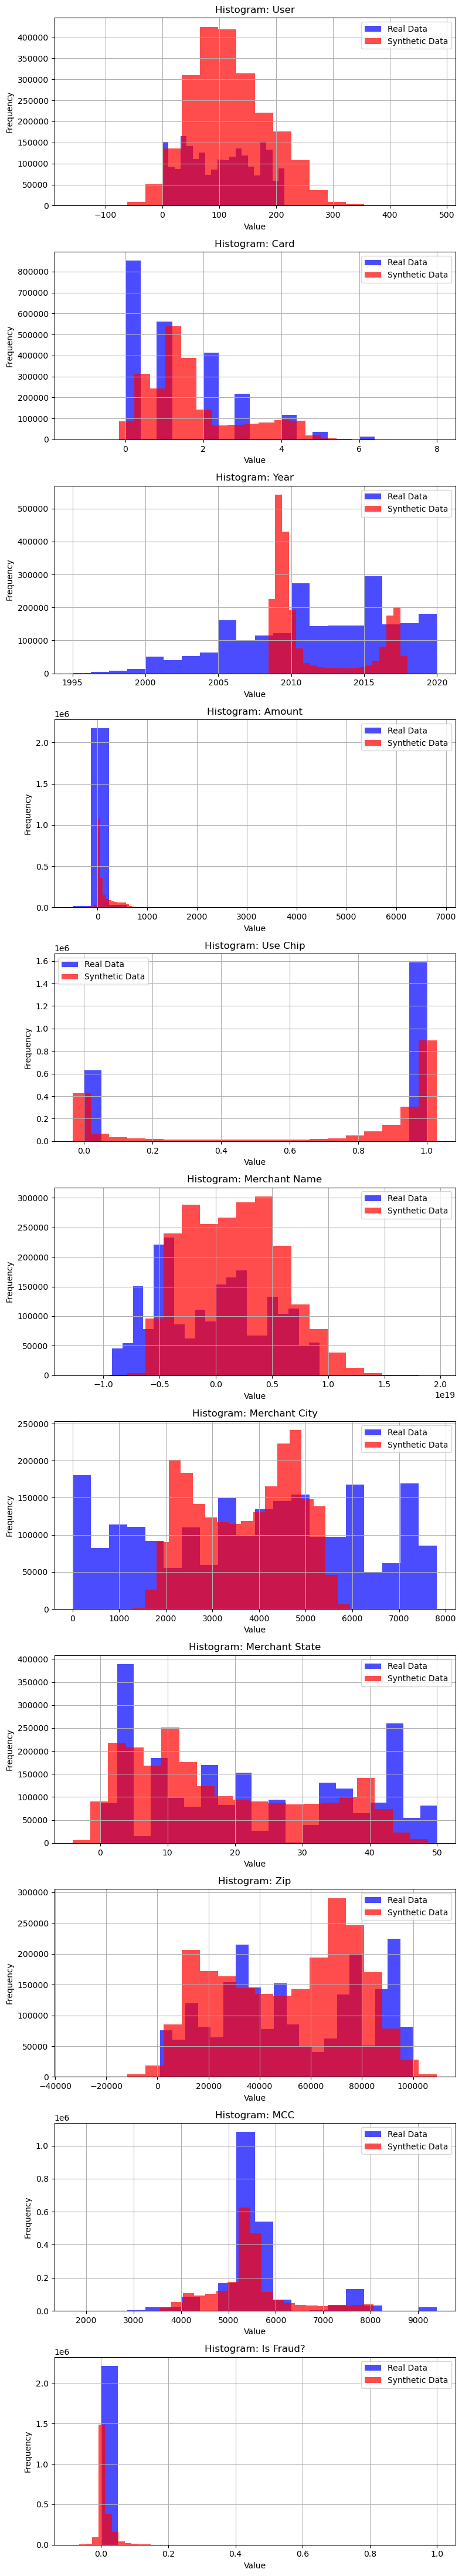

In [28]:
plot_columnwise_distribution(data = data, synthetic_df = synthetic_df)

**Plotting the gaussian distribution of real and synthetic data columnwise:**

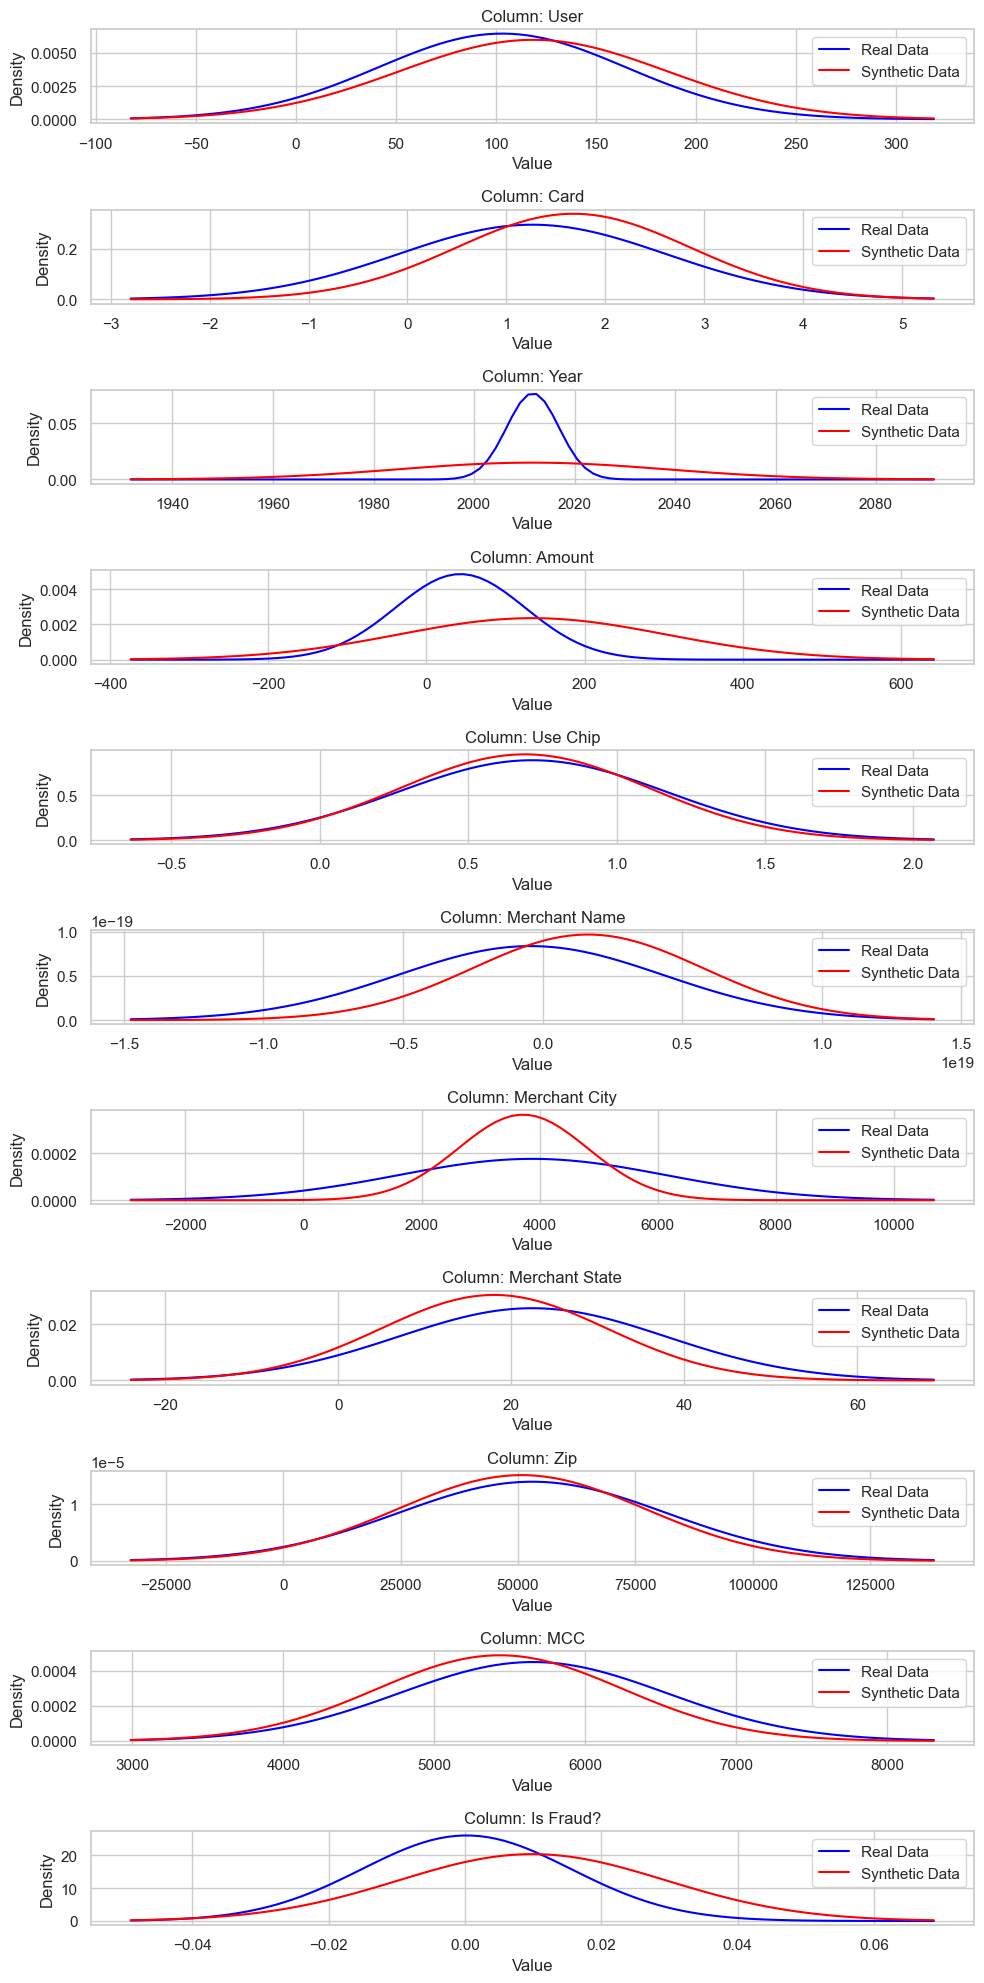

In [29]:
plot_columnwise_normal_distribution(data = data, synthetic_df = synthetic_df)

**2. Evaluation metrics:**

In [30]:
X = data

# Calculate Jensen-Shannon Divergence (JSD) for each column
jsd_values = {}
for col in X.columns:
    p = np.histogram(X[col], bins=50, density=True)[0]
    q = np.histogram(synthetic_df[col], bins=50, density=True)[0]
    jsd = (entropy((p + q) / 2) - (entropy(p) + entropy(q)) / 2)
    jsd_values[col] = jsd
print("\nJensen-Shannon Divergence (JSD) for each column:")
for col, jsd in jsd_values.items():
    print(f"{col}: {jsd}")

# Calculate Kolmogorov-Smirnov Test (KS Test) for each column
ks_statistic_values = {}
ks_p_values = {}
for col in X.columns:
    ks_statistic, ks_p_value = ks_2samp(X[col].values, synthetic_df[col].values)
    ks_statistic_values[col] = ks_statistic
    ks_p_values[col] = ks_p_value

print("\nKolmogorov-Smirnov Test (KS Test) for each column:")
for col, ks_statistic in ks_statistic_values.items():
    print(f"{col}: Statistic={ks_statistic}, p-value={ks_p_values[col]}")


Jensen-Shannon Divergence (JSD) for each column:
User: 0.3798091643576966
Card: 0.5471137433010371
Year: 0.4066287062805043
Month: 0.6098559707212847
Day: 0.21963696356936602
Time: 0.15465227383972913
Amount: 1.0691709338801498
Use Chip: 0.31284660093198813
Merchant Name: 0.24778388673200746
Merchant City: 0.11896325975346134
Merchant State: 0.18943446686906373
Zip: 0.17292744464648457
MCC: 0.44039724467483765
Is Fraud?: 1.0207426888703592

Kolmogorov-Smirnov Test (KS Test) for each column:
User: Statistic=0.14069693750747073, p-value=0.0
Card: Statistic=0.38379646231255515, p-value=0.0
Year: Statistic=0.27798789797856094, p-value=0.0
Month: Statistic=0.4937390194340512, p-value=0.0
Day: Statistic=0.4603147968975884, p-value=0.0
Time: Statistic=0.2614126843438273, p-value=0.0
Amount: Statistic=0.3565139141672136, p-value=0.0
Use Chip: Statistic=0.4577374226708796, p-value=0.0
Merchant Name: Statistic=0.263575080571136, p-value=0.0
Merchant City: Statistic=0.2679959494538754, p-value=0

**3. Evaluation metrics discussed in the class (Coarse grained evaluation):**

In [31]:
total_data = pd.concat([data, synthetic_df], axis=0)
total_data.shape

(4433970, 14)

**1. Total number of duplicates in Original + Synthetic dataset:**

In [32]:
dup_total = len(total_data) - len(total_data.drop_duplicates())
dup_total

19

**2. Total number of duplicates in Original dataset:**

In [33]:
dup_real = (len(data) - len(data.drop_duplicates()))
dup_real

19

**3. Total number of duplicates in Synthetic dataset:**

In [34]:
dup_synthetic = len(synthetic_df) - len(synthetic_df.drop_duplicates())
dup_synthetic

0

**4 Total copies:**

In [35]:
copies = dup_total - dup_real - dup_synthetic
copies

0

**5. Percentage of synthetic data which is a self-copy:**

In [42]:
print(f'{(len(synthetic_df) - len(synthetic_df.drop_duplicates())) / (len(synthetic_df)) * 100} %')

0.0 %


---